In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Sequential
from keras.models import load_model

In [ ]:
print(tf. __version__)

2.18.0


In [ ]:
ds = keras.utils.image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab Notebooks/Pateto_Project/pateto_project',
    batch_size=32,
    image_size=(256,256),
)

Found 2152 files belonging to 3 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_names = ds.class_names

In [ ]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
class_indices = {i: class_name for i, class_name in enumerate(class_names)}
print(class_indices)

{0: 'Potato___Early_blight', 1: 'Potato___Late_blight', 2: 'Potato___healthy'}


In [ ]:
import json
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

In [ ]:
len(ds)

68

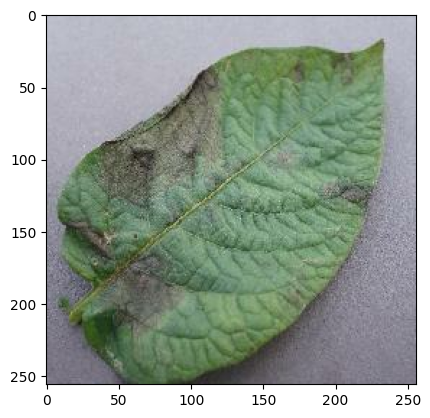

In [ ]:
for image_batch, label in ds.take(1):
#  print(image_batch[0])
  plt.imshow(image_batch[0].numpy().astype('uint8'))

# Spliting Data into Train, Test and Validation set

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_rescale = Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

In [ ]:
model = Sequential()

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
n_classes = 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Resizing, Rescaling

# Define the Model
model = Sequential()

In [ ]:
# Add Preprocessing Layer FIRST
model.add(resize_rescale)

# Convolutional Layers
model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2, 2))  # (127, 127)

model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(2, 2))  # (62, 62)

# Use padding='same' to prevent excessive shrinking
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))  # (31, 31)

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))  # (15, 15)

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))  # (7, 7)

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(2, 2))  # (3, 3)

# Flatten and Fully Connected Layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Prevents overfitting

# Output Layer
model.add(Dense(3, activation='softmax'))  # 3 classes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Model Summary
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 15, 15, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,227 (797.76 KB)

 Trainable params: 204,227 (797.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
md = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    epochs=28
)

Epoch 1/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 316s 528ms/step - accuracy: 0.4710 - loss: 1.0016 - val_accuracy: 0.4740 - val_loss: 0.8738
Epoch 2/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.5150 - loss: 0.8763 - val_accuracy: 0.7552 - val_loss: 0.5569
Epoch 3/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.7119 - loss: 0.6476 - val_accuracy: 0.8750 - val_loss: 0.3374
Epoch 4/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.7446 - loss: 0.6123 - val_accuracy: 0.8229 - val_loss: 0.3948
Epoch 5/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.7857 - loss: 0.4778 - val_accuracy: 0.8750 - val_loss: 0.3353
Epoch 6/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.8132 - loss: 0.4156 - val_accuracy: 0.8281 - val_loss: 0.5314
Epoch 7/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.8619 - loss: 0.3505 - val_accuracy: 0.9010 - val_loss: 0.2304
Epoch 8/28
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.8858 - loss: 0.3083 - val_acc

In [ ]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9986 - loss: 0.0110


[0.015424500219523907, 0.99609375]

In [ ]:
import numpy as np

first image to predict
actual_label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
predicted label: Potato___Late_blight


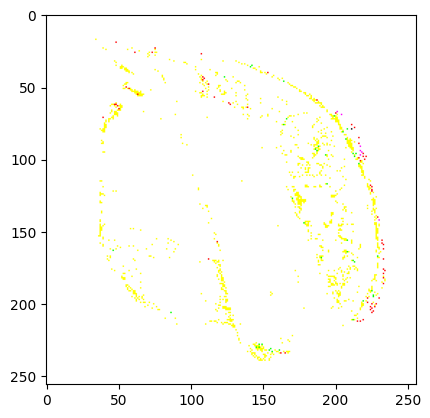

In [ ]:
for image_batch, label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print ("first image to predict")
  plt.imshow(image_batch[0])
  print ("actual_label: ", class_names[first_label])

  batch_predict = model.predict(image_batch)
  print("predicted label:",class_names[np.argmax(batch_predict[0])])

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [ ]:
model.save("../potatoes.h5")

In [ ]:
model.save('cnn_model.h5')

# 30 (with Padding)

Text(0.5, 1.0, 'Training and Validation Accuracy')

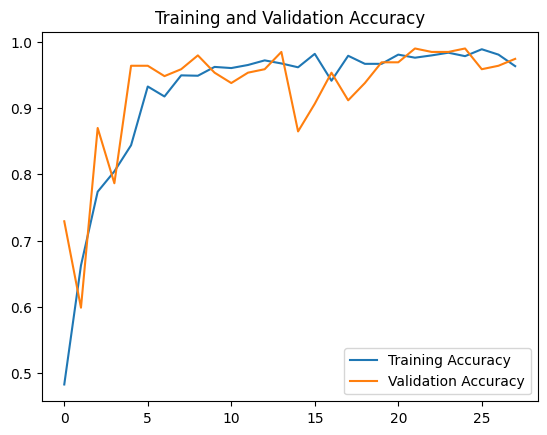

In [ ]:
plt.plot(range(28), md.history['accuracy'], label='Training Accuracy')
plt.plot(range(28), md.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


Text(0.5, 1.0, 'Training and Validation Accuracy')

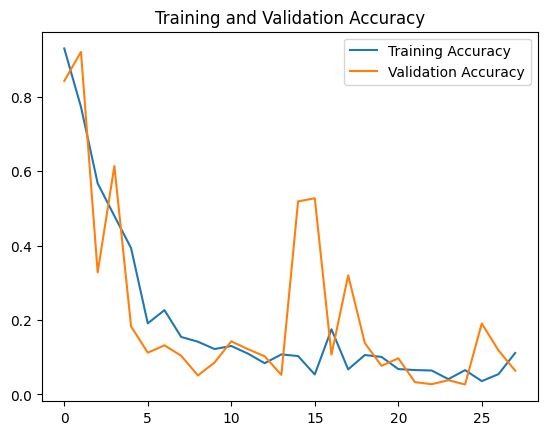

In [ ]:
plt.plot(range(28), md.history['loss'], label='Training Accuracy')
plt.plot(range(28), md.history['val_loss'], label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

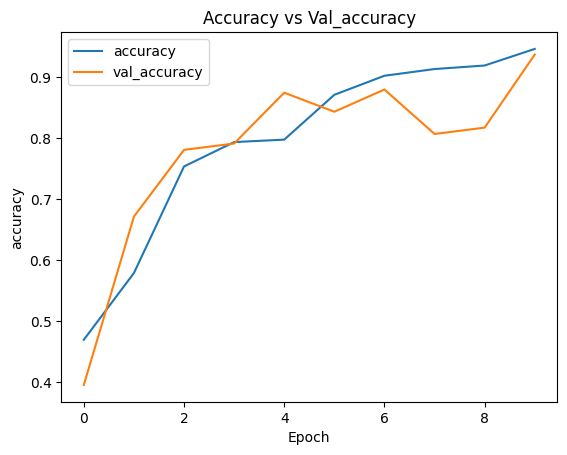

In [ ]:
plt.title("Accuracy vs Val_accuracy")
plt.plot(md.history['accuracy'], label='accuracy')
plt.plot(md.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

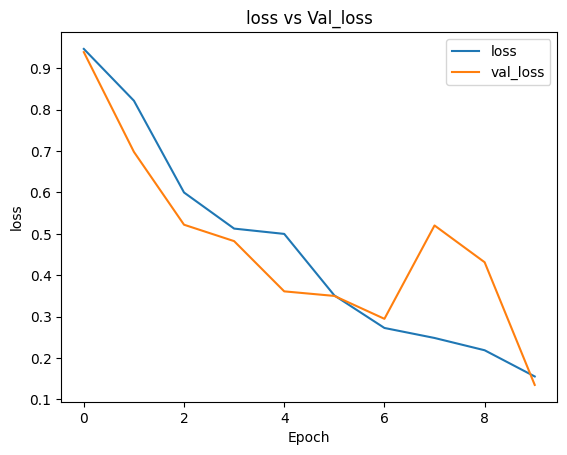

In [ ]:
plt.title("loss vs Val_loss")
plt.plot(md.history['loss'], label='loss')
plt.plot(md.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

# 13 epoch

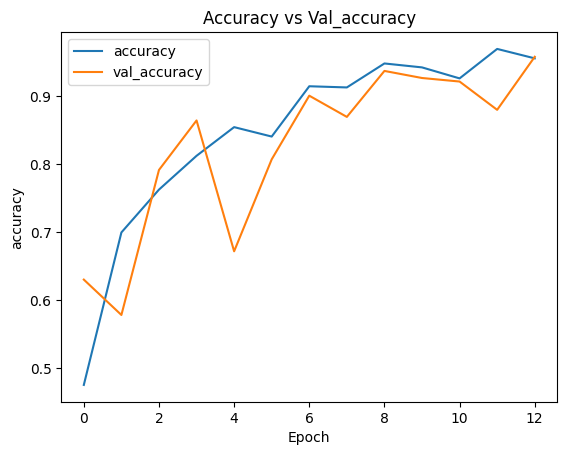

In [ ]:
plt.title("Accuracy vs Val_accuracy")
plt.plot(md.history['accuracy'], label='accuracy')
plt.plot(md.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

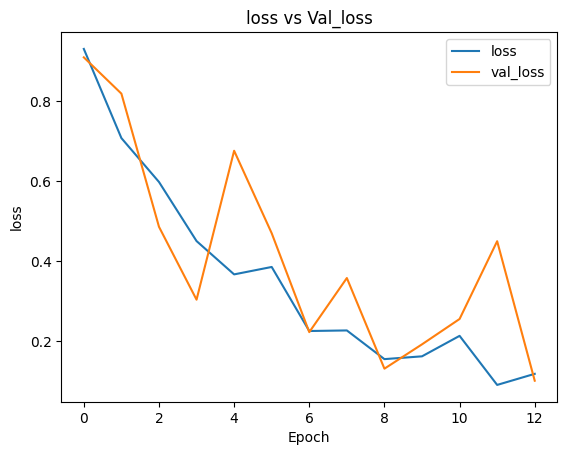

In [ ]:
plt.title("loss vs Val_loss")
plt.plot(md.history['loss'], label='loss')
plt.plot(md.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

#20 epoch

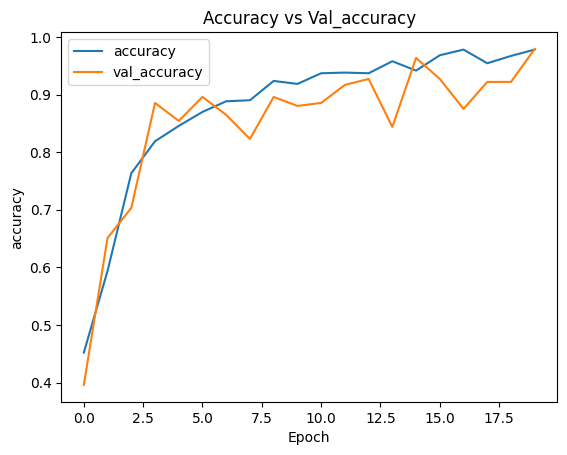

In [ ]:
plt.title("Accuracy vs Val_accuracy")
plt.plot(md.history['accuracy'], label='accuracy')
plt.plot(md.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

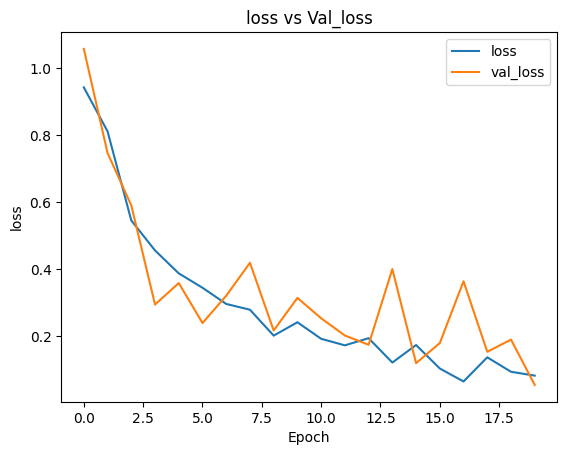

In [ ]:
plt.title("loss vs Val_loss")
plt.plot(md.history['loss'], label='loss')
plt.plot(md.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
model.save("new_cnnk_model_tf.keras")

In [ ]:
model.save("new_cnn_model_tf.h5")